In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [2]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [ ]:
#### Droppa il primo caso e tiene il secondo con HBOND e VDW

#columns_to_check = df.columns[:-1]
#df_copy = df.copy()
#df = df.drop_duplicates(subset=columns_to_check, keep='last')

In [9]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [10]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_17126/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [11]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [12]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


In [13]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  


## Feature engineering


*   Sum
*   Product
*   Absolute difference
*   Average



In [15]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names


In [16]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

for feature in features:
  feature_names.extend(fe(feature))

Engineering feature: ss8_encoded
   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  t_ss8_encoded  \
0  ...  0.533 -0.277  1.648          6.0              3              7   
1  ... -0.862 -1.020 -0.255          4.0              0              1   
2  ... -3.005 -0.503 -1.853          2.0              2              0   
3  ... -4.760  0.670 -2.647         17.0              4              4   
4  ...  1.477  0.113 -0.837         13.0              0              3   

   ss8_encoded_sum  ss8_encoded_abs

In [18]:
print(feature_names)

['s_ss8', 's_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 'ss8_encoded_sum', 'ss8_encoded_abs_diff', 'ss8_encoded_prod', 'ss8_encoded_avg', 'rsa_sum', 'rsa_abs_diff', 'rsa_prod', 'rsa_avg', 'phi_sum', 'phi_abs_diff', 'phi_prod', 'phi_avg', 'psi_sum', 'psi_abs_diff', 'psi_prod', 'psi_avg', 'a1_sum', 'a1_abs_diff', 'a1_prod', 'a1_avg', 'a2_sum', 'a2_abs_diff', 'a2_prod', 'a2_avg', 'a3_sum', 'a3_abs_diff', 'a3_prod', 'a3_avg', 'a4_sum', 'a4_abs_diff', 'a4_prod', 'a4_avg', 'a5_sum', 'a5_abs_diff', 'a5_prod', 'a5_avg', '3di_state_sum', '3di_state_abs_diff', '3di_state_prod', '3di_state_avg']


## Scaling features

In [12]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [14]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 675794
1: 471719
2: 24501
3: 22650
4: 5686
5: 1344
6: 1146
7: 697310


In [15]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train_bal)):
    print(f"{label}: {Counter(y_train_bal)[label]}")


Resampled y_train_bal distribution
0: 675794
1: 471719
2: 24501
3: 22650
4: 20000
5: 10000
6: 10000
7: 697310


## 2 - LOAD Existing data


In [ ]:
# X_bal = np.load(path + '/X_bal-SMOTE22.npy')
# y_bal = np.load(path + '/y_bal-SMOTE22.npy')

In [ ]:
# print('Original y_train distribution:', Counter(y_train))
# print('Resampled y_bal distribution:', Counter(y_bal))

In [ ]:
# # Count the class in X_bal
# unique_values, counts = np.unique(y_bal, return_counts=True)
# print(dict(zip(unique_values, counts)))

In [16]:
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

## XGBoost

### Helper functions

In [17]:
def feature_importance(model, interaction_type, feature_names):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [18]:
def compute_metrics(y_test, y_pred, y_pred_prob):
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.4f}')
  balanced_acc = balanced_accuracy_score(y_test, y_pred)
  print(f'Balanced Accuracy: {balanced_acc:.4f}')
  auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
  print(f'AUC-ROC: {auc_roc:.4f}')
  mcc = matthews_corrcoef(y_test, y_pred)
  print(f'Matthews Correlation Coefficient: {mcc:.4f}')
  average_precision = average_precision_score(y_test, y_pred_prob, average='weighted')
  print(f'Average Precision Score: {average_precision:.4f}')

In [19]:
def plot_confusion_matrix(y_test, y_pred, labels, interaction_type):
  cm = confusion_matrix(y_test, y_pred)
  labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
  cm_df = pd.DataFrame(cm, index=labels, columns=labels)

  #plot
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix for {interaction_type} interaction')
  plt.show()

### Train loop

Training classifier for Class 0


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:50:14] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.63420
[100]	validation-auc:0.71388
[186]	validation-auc:0.71594

Binary Classification Report for Class 0
Accuracy: 0.6422
Balanced Accuracy: 0.6573


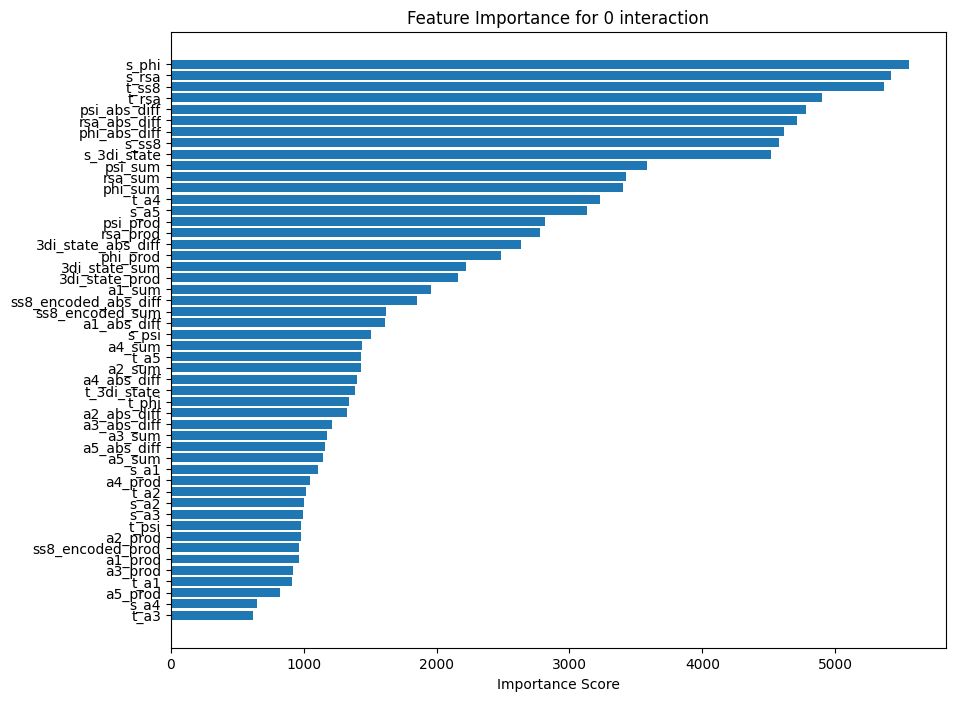

Training classifier for Class 1


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.53851
[46]	validation-auc:0.55036

Binary Classification Report for Class 1
Accuracy: 0.5208
Balanced Accuracy: 0.5361


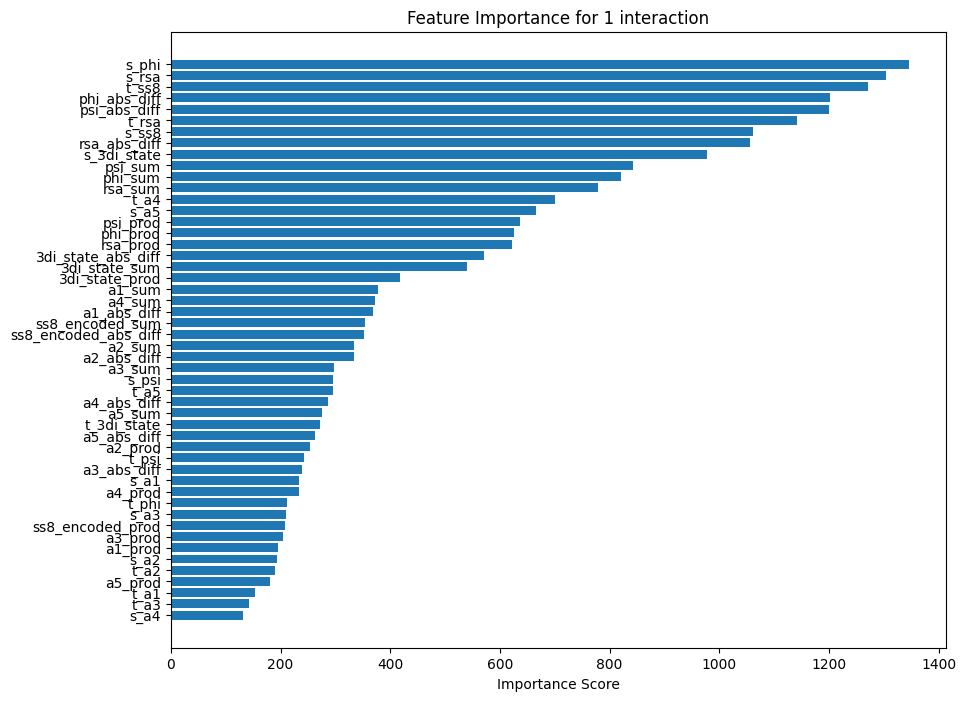

Training classifier for Class 2


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.99029
[53]	validation-auc:0.99088

Binary Classification Report for Class 2
Accuracy: 0.9791
Balanced Accuracy: 0.9872


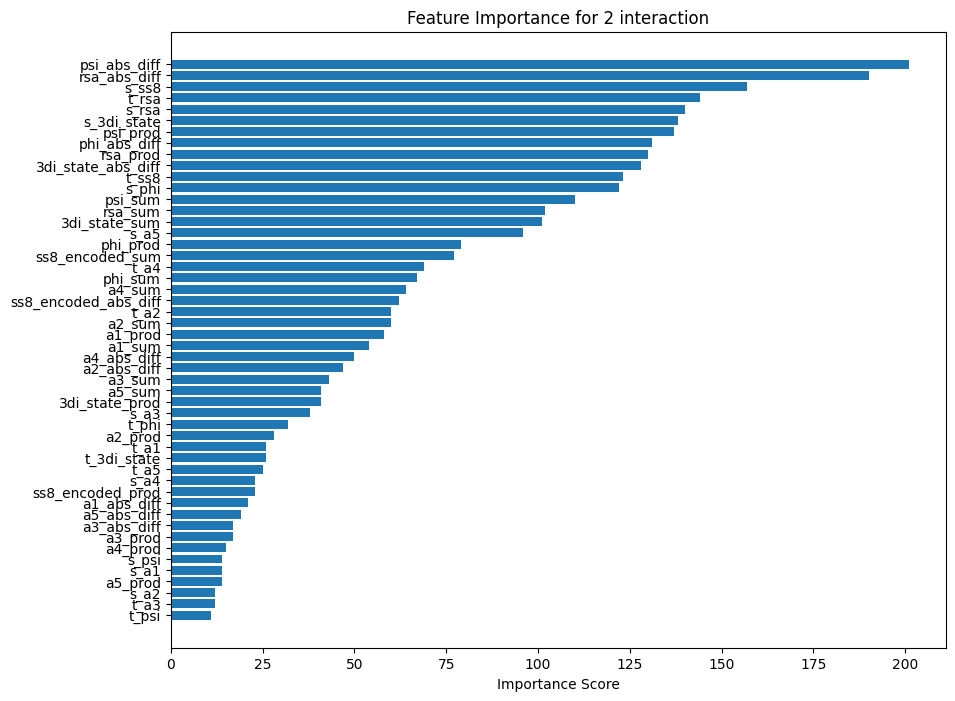

Training classifier for Class 3


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:51:04] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.97661
[43]	validation-auc:0.97780

Binary Classification Report for Class 3
Accuracy: 0.9421
Balanced Accuracy: 0.9619


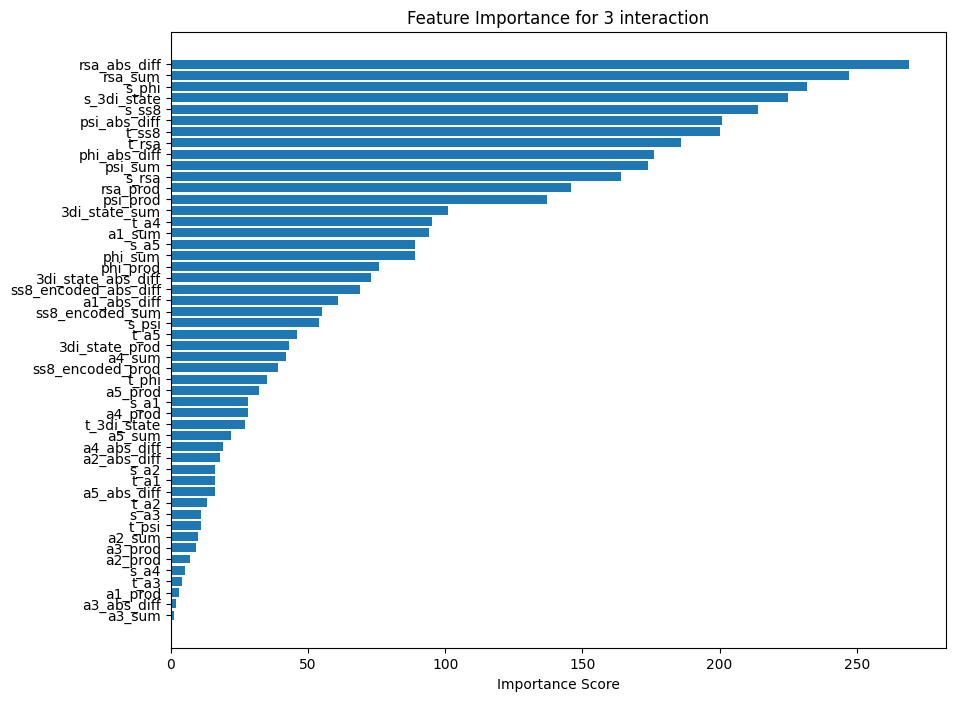

Training classifier for Class 4


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.98945
[43]	validation-auc:0.99066

Binary Classification Report for Class 4
Accuracy: 0.9788
Balanced Accuracy: 0.9560


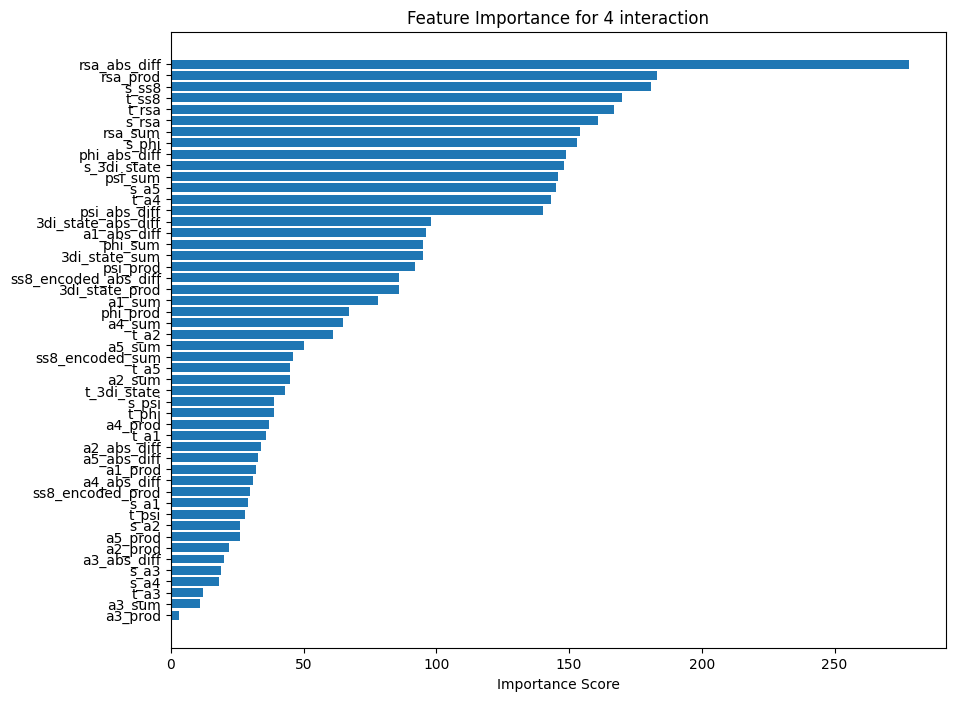

Training classifier for Class 5


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.99945
[36]	validation-auc:0.99951

Binary Classification Report for Class 5
Accuracy: 0.9991
Balanced Accuracy: 0.9734


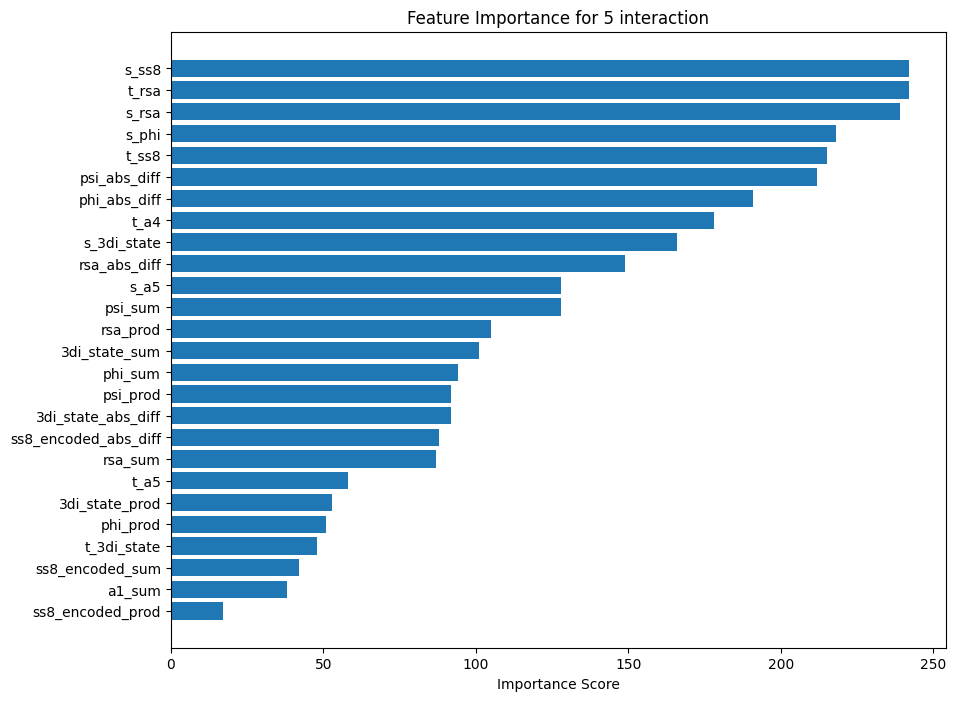

Training classifier for Class 6


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.94134
[47]	validation-auc:0.95504

Binary Classification Report for Class 6
Accuracy: 0.9838
Balanced Accuracy: 0.7574


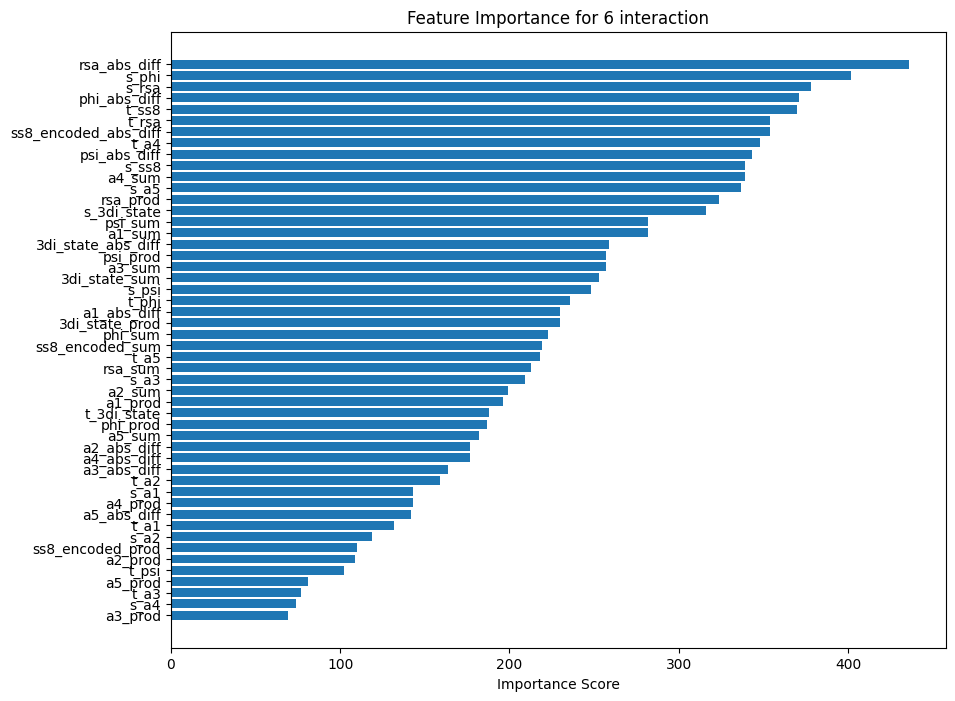

Training classifier for Class 7


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.65380
[100]	validation-auc:0.74461
[200]	validation-auc:0.75653
[300]	validation-auc:0.76292
[400]	validation-auc:0.76850
[500]	validation-auc:0.77258
[600]	validation-auc:0.77553
[700]	validation-auc:0.77826
[800]	validation-auc:0.78037
[900]	validation-auc:0.78246
[1000]	validation-auc:0.78433
[1100]	validation-auc:0.78583
[1200]	validation-auc:0.78737
[1300]	validation-auc:0.78880
[1400]	validation-auc:0.78997
[1500]	validation-auc:0.79111
[1600]	validation-auc:0.79223
[1700]	validation-auc:0.79321
[1800]	validation-auc:0.79422
[1900]	validation-auc:0.79509
[2000]	validation-auc:0.79597
[2100]	validation-auc:0.79695
[2200]	validation-auc:0.79778
[2300]	validation-auc:0.79859
[2400]	validation-auc:0.79933
[2499]	validation-auc:0.80009

Binary Classification Report for Class 7
Accuracy: 0.7396
Balanced Accuracy: 0.7170


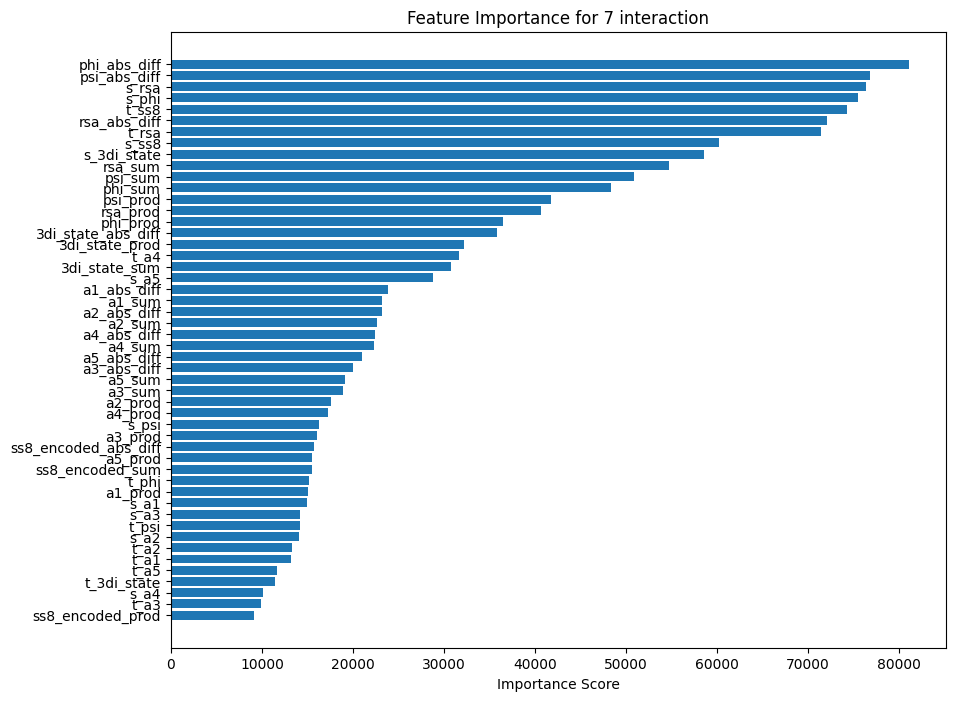

In [ ]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_train))))

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):
    print(f'Training classifier for Class {num_class}')

    # Create binary labels for ALL training examples
    # 1 for current class, 0 for all other classes
    y_train_binary = (y_train_bal == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)

    # Binary labels for test data
    y_test_binary = (y_test == num_class).astype(int)

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train_bal, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)
    dtest = xgb.DMatrix(X_test, label=y_test_binary)

    # Counte num positive/negative examples for this class
    pos_class = np.sum(y_train_binary == 1)
    neg_class = np.sum(y_train_binary == 0)

    # Train model
    model = xgb.train(
        params = {
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 10,
            'learning_rate': 0.2,
            'scale_pos_weight': neg_class / pos_class if pos_class > 0 else 1.0,  # Handle class imbalance
            'seed': 42
        },
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=100
    )

    # Save model
    os.makedirs(os.path.join(path, 'models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/xgboost_model_class_{num_class}.json'))

    # Store predictions for this class
    y_pred_prob = model.predict(dtest)
    all_class_predictions[:, num_class] = y_pred_prob

    # Evaluate this binary classifier
    y_pred = (y_pred_prob > 0.5).astype(int)
    print(f"\nBinary Classification Report for Class {num_class}")
    print(f"Accuracy: {accuracy_score(y_test_binary, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_pred):.4f}")

    # Optional: Display feature importance for this classifier
    feature_importance(model, num_class, feature_names)

    # Store the model
    models.append(model)

# Final multi-class predictions (choose class with highest probability)
# final_predictions = np.argmax(all_class_predictions, axis=1)

# Evaluate overall multi-class performance
# print("\n==== Overall Multi-class Performance ====")
# compute_metrics(y_test, final_predictions, all_class_predictions)
# plot_confusion_matrix(y_test, final_predictions, np.unique(y))

In [20]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict

def analyze_xgboost_model(model_path):
    """Analyze an XGBoost model JSON file and extract useful information."""
    with open(model_path, 'r') as f:
        model_data = json.load(f)
    
    # Extract basic model information
    results = {}
    
    # Model metadata and version
    results['version'] = '.'.join(map(str, model_data.get('learner', {}).get('version', ["unknown"])))
    
    # Model attributes (parameters)
    attributes = model_data.get('learner', {}).get('attributes', {})
    results['best_iteration'] = int(attributes.get('best_iteration', -1))
    results['best_score'] = float(attributes.get('best_score', -1))
    
    # Extract hyperparameters
    for key in ['max_depth', 'learning_rate', 'objective', 'eval_metric', 'num_class', 
                'scale_pos_weight', 'seed', 'num_parallel_tree', 'subsample', 'colsample_bytree']:
        if key in attributes:
            try:
                value = attributes[key]
                # Convert numeric strings to proper types
                if isinstance(value, str) and value.replace('.', '', 1).isdigit():
                    if '.' in value:
                        results[key] = float(value)
                    else:
                        results[key] = int(value)
                else:
                    results[key] = value
            except:
                results[key] = attributes[key]
    
    # Extract tree information
    tree_model = model_data.get('learner', {}).get('gradient_booster', {}).get('model', {})
    
    # Tree model parameters
    gbtree_params = tree_model.get('gbtree_model_param', {})
    results['num_trees'] = int(gbtree_params.get('num_trees', 0))
    
    # Trees analysis
    trees = tree_model.get('trees', [])
    
    # Tree statistics
    tree_stats = []
    total_nodes = 0
    total_leaves = 0
    used_features = set()
    feature_importance = defaultdict(int)
    
    for i, tree in enumerate(trees):
        tree_param = tree.get('tree_param', {})
        num_nodes = int(tree_param.get('num_nodes', 0))
        split_indices = tree.get('split_indices', [])
        
        # Calculate leaves (nodes that are not internal nodes)
        internal_nodes = set()
        for j in range(len(tree.get('left_children', []))):
            if tree['left_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)
            if tree['right_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)
        
        num_leaves = num_nodes - len(internal_nodes)
        
        # Track feature usage as a simple feature importance
        for feature_idx in split_indices:
            used_features.add(feature_idx)
            feature_importance[feature_idx] += 1
        
        # Store tree statistics
        tree_stats.append({
            'tree_index': i,
            'num_nodes': num_nodes,
            'num_leaves': num_leaves,
            'max_depth': max_tree_depth(tree),
            'num_features_used': len(set(split_indices))
        })
        
        total_nodes += num_nodes
        total_leaves += num_leaves
    
    results['total_nodes'] = total_nodes
    results['total_leaves'] = total_leaves
    results['avg_nodes_per_tree'] = total_nodes / results['num_trees'] if results['num_trees'] > 0 else 0
    results['avg_leaves_per_tree'] = total_leaves / results['num_trees'] if results['num_trees'] > 0 else 0
    results['num_features_used'] = len(used_features)
    
    # Sort feature importance
    results['top_features'] = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # Compute tree depth statistics
    depths = [stat['max_depth'] for stat in tree_stats]
    results['min_tree_depth'] = min(depths) if depths else 0
    results['max_tree_depth'] = max(depths) if depths else 0
    results['avg_tree_depth'] = sum(depths) / len(depths) if depths else 0
    
    # File metrics
    results['file_size_kb'] = os.path.getsize(model_path) / 1024
    
    return results, tree_stats

def max_tree_depth(tree):
    """Calculate the maximum depth of a tree by following child nodes."""
    left = tree.get('left_children', [])
    right = tree.get('right_children', [])
    
    if not left or not right:
        return 0
        
    # Use BFS to find the maximum depth
    depths = {0: 0}  # node_id: depth
    max_depth = 0
    
    for node_id in range(len(left)):
        node_depth = depths.get(node_id, 0)
        
        # Process left child
        if left[node_id] >= 0:  # Valid node
            depths[left[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)
            
        # Process right child
        if right[node_id] >= 0:  # Valid node
            depths[right[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)
            
    return max_depth

# Usage example
models_dir = '/Users/sebastianosanson/Development/Contacts-Classification/models'
all_model_results = []
all_tree_stats = []

# Process all model files
for filename in sorted(os.listdir(models_dir)):
    if filename.endswith('.json'):
        model_path = os.path.join(models_dir, filename)
        class_num = int(filename.split('_')[-1].split('.')[0])
        
        # Extract model information
        model_info, tree_stats = analyze_xgboost_model(model_path)
        model_info['class'] = class_num
        
        # Add model information to results
        all_model_results.append(model_info)
        
        # Add tree statistics with model identifier
        for stat in tree_stats:
            stat['class'] = class_num
            all_tree_stats.append(stat)

# Create DataFrame for easy analysis
models_df = pd.DataFrame(all_model_results)
trees_df = pd.DataFrame(all_tree_stats)

# Print the high-level model information
print("\n===== MODEL INFORMATION =====")
print(models_df[['class', 'num_trees', 'best_iteration', 'best_score', 
                 'total_nodes', 'avg_nodes_per_tree', 'avg_tree_depth', 
                 'file_size_kb']].sort_values('class'))

# Print tree depth statistics
print("\n===== TREE DEPTH STATISTICS =====")
tree_depth_stats = trees_df.groupby('class').agg({
    'max_depth': ['min', 'max', 'mean']
}).reset_index()
print(tree_depth_stats)

# Feature importance across models
print("\n===== TOP FEATURES BY CLASS =====")
for i, model in enumerate(all_model_results):
    print(f"\nClass {model['class']} top features:")
    for feature_idx, count in model['top_features'][:10]:
        print(f"  Feature {feature_names[feature_idx]}: used {count} times")


===== MODEL INFORMATION =====
   class  num_trees  best_iteration  best_score  total_nodes  \
0      0        187             166    0.716235       224745   
1      1         47              26    0.551998        51013   
2      2         55              34    0.991228         6873   
3      3         44              23    0.978187         7904   
4      4         45              24    0.991081         8027   
5      5         38              17    0.999565         6586   
6      6         48              27    0.956693        23162   
7      7       2500            2497    0.800087      3151678   

   avg_nodes_per_tree  avg_tree_depth   file_size_kb  
0         1201.844920       10.000000   77566.831055  
1         1085.382979       10.000000    3122.578125  
2          124.963636       10.000000     427.916016  
3          179.636364       10.000000     483.952148  
4          178.377778       10.000000     492.868164  
5          173.315789        9.052632     404.999023  
6      